In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchbnn as bnn
from tqdm import tqdm


In [2]:
def prepare_data(data, train_size=0.8):
    X = torch.tensor(data.loc[:, ["x_i1", "x_i2"]].values).float()
    Y = torch.tensor(data.l_i.values)
    dataset = torch.utils.data.TensorDataset(X, Y)
    train_size = round(X.shape[0] * train_size)
    test_size = X.shape[0] - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, (train_size, test_size)
    )
    return train_dataset, test_dataset

In [3]:
def train_model(model, data_loader, epochs = 200,
                klloss = bnn.BKLLoss(reduction='mean', last_layer_only=False),
                kl_weight = 0.001,
                ce_loss = nn.CrossEntropyLoss(),
                lr = 0.01
                ):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        if epoch != 0:
            pbar.set_description('(Accuracy: {:.2f}%, CE : {:.2f}, KL : {:.2f}) - Progress'.format(accuracy,ce.item(), kl.item()))
        for data, target in data_loader:
            prediction = model(data)
            ce = ce_loss(prediction, target)
            kl = klloss(model)
            cost = ce + kl_weight * kl

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        _, predicted = torch.max(prediction.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum()
        accuracy = (100 * float(correct) / total)
        #print('    - Accuracy: {:.2f}%, CE : {:.2f}, KL : {:.2f}'.format(accuracy,ce.item(), kl.item()), end='\r')




In [4]:
data_a = pd.read_excel('./data/trainingdata_a.xls')
data_a.head(10)

,Unnamed: 0,x_i1,x_i2,l_i
0,x_1,0.780742,0.412337,0
1,x_2,0.623970,0.940464,0
2,x_3,0.891573,0.435562,0
3,x_4,0.590270,0.586359,1
4,x_5,0.903968,0.631883,0
5,x_6,0.456845,0.657686,1
6,x_7,0.659014,0.860302,0
7,x_8,0.865433,0.398123,0
8,x_9,0.390158,0.848540,0
9,x_10,0.721975,0.811998,0


In [5]:
train_dataset, test_dataset = prepare_data(data_a)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

In [6]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=8),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=8, out_features=2),
)
model

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=8, out_features=2, bias=True)
)

In [7]:
train_model(model, train_data_loader)
print("\nTraining done.")


(Accuracy: 100.00%, CE : 0.23, KL : 77.24) - Progress: 100%|██████████| 200/200 [00:27<00:00,  7.40it/s]
Training done.



In [8]:
def plot_predictions(test_dataset, predictions):
    X_test = test_dataset.dataset.tensors[0]
    Y_test = test_dataset.dataset.tensors[1]
    fig = plt.figure(figsize = (16, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.scatter(np.array(X_test[Y_test==0])[:, 0], np.array(X_test[Y_test==0])[:, 1], c="red", label="0", s=5)
    ax1.scatter(np.array(X_test[Y_test==1])[:, 0], np.array(X_test[Y_test==1])[:, 1], c="green", label="1", s=5)
    ax1.legend()
    ax1.set_title("Correct")
    
    ax2.scatter(np.array(X_test[predictions==0])[:, 0], np.array(X_test[predictions==0])[:, 1], c="red", label="0", s=5)
    ax2.scatter(np.array(X_test[predictions==1])[:, 0], np.array(X_test[predictions==1])[:, 1], c="green", label="1", s=5)
    ax2.legend()
    ax2.set_title("Predicted")
    plt.show()

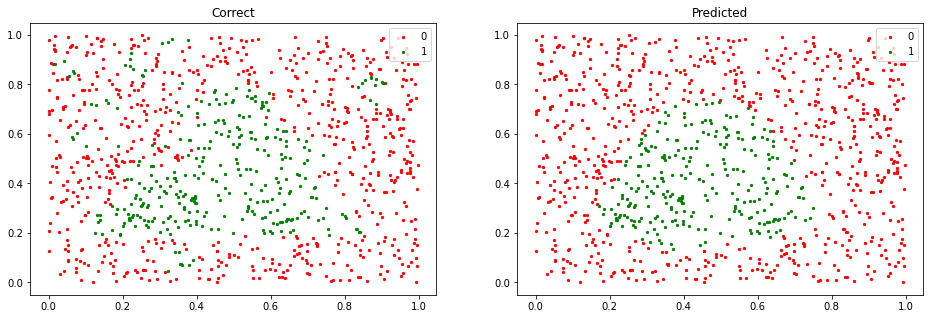

In [9]:
_, predicted = torch.max(model(test_dataset.dataset.tensors[0]), 1)
plot_predictions(test_dataset, np.array(predicted))


## Average model
Since the weights of the network are a distribution the prediction will be different each time. Therefore we can make multiple predictions with the same input and will receive different outputs which will reflect the certainty of the network for the given input. 

In [10]:
# Try averaging predictions
with torch.no_grad():
    predictions = []
    for i in range(500):
        predictions.append(np.array(model(test_dataset.dataset.tensors[0])))
predictions = np.array(predictions)
predictions.shape

(500, 1000, 2)

For a input we can print the distribution of output values given by the network. 

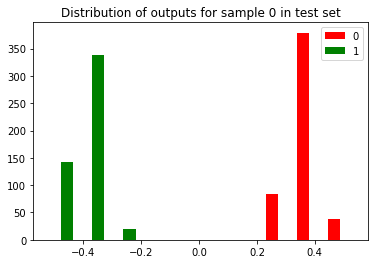

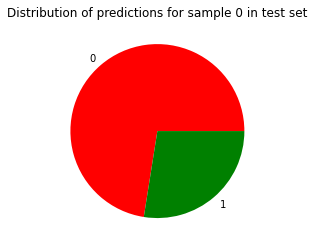

In [11]:

def plot_sample(sample, prediction_output):
    plt.hist(prediction_output[:, sample], 10, color=["red", "green"], label=[0, 1])
    plt.legend()
    plt.title("Distribution of outputs for sample {} in test set".format(sample))
    plt.show()

    values, counts = np.unique(np.argmax(prediction_output, 2)[sample], return_counts=True)
    count_0 = (np.argmax(prediction_output, 2)[sample] == 0).sum()
    count_1 = (np.argmax(prediction_output, 2)[sample] == 1).sum()
    plt.pie([count_0, count_1], labels=[0, 1], colors=["red", "green"])
    plt.title("Distribution of predictions for sample {} in test set".format(sample))
    plt.show()

plot_sample(0, predictions)




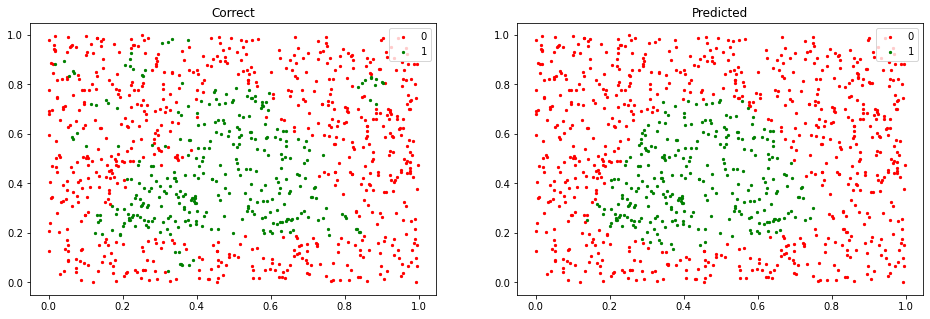

In [12]:
predictions_of_average_network = np.argmax(np.average(predictions, 0), 1)
plot_predictions(test_dataset, predictions_of_average_network)

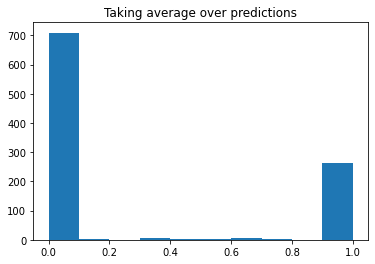

In [13]:
average_prediction_over_networks = np.average(np.argmax(predictions, 2), 0)
plt.title("Taking average over predictions")
plt.hist(average_prediction_over_networks)
plt.show()